In [1]:
import numpy as np
import sys
import itertools as itertools
sys.path.append("..")
sys.path.append("../..")

import matplotlib.pyplot as plt
from python.Hubbard import *
from python.DMRG import DMRG
from python.Zippers import MPO_to_Hamiltonian, contract_MPS
from python.Canonical_Form import get_Neumann_entropy
from python.Backend import Backend

In [2]:
n_sites = 50
hopping_t = 1.0

In [3]:
device = "numpy"
# device = "torch"

bk = Backend(device)

NKeep = 50
NSweep = 20
Krylov_bases = 5 #* 5 is usually enough
Lanczos_cutoff = 1e-2
iterative_diag = True
two_site = True
verbose = True

In [4]:
import numpy.typing as npt
import pickle
from dataclasses import dataclass, field, asdict, replace
from copy import deepcopy
from typing import Any, Optional
from pathlib import Path


@dataclass
class Params:
    L: int
    t: float
    U: float
    mu: float
    NKeep: int
    NSweep: int
    diag: bool
    Krylov: int
    cutoff: float
    two: bool
    
    def to_log(self) -> str:
        log_dict = asdict(self)
        
        log_dict['t'] = round(self.t, 2)
        log_dict['U'] = round(self.U, 2)
        log_dict['mu'] = round(self.mu, 2)
        log_dict['cutoff'] = round(self.cutoff, 3)
        
        # Filter out keys where the value is None
        filtered_log_dict = {key: log for key, log in log_dict.items() if log is not None}
        
        # Create log string
        return "_".join(
            f"{key}={log}" for key, log in filtered_log_dict.items()
        )

@dataclass
class Results:
    ground_MPS: list[npt.NDArray]
    ground_state_energy: float
    Neumann_entropy: float
    filling: list[float] | npt.NDArray[np.float64] = field(default_factory=list)
    double_occupancy: list[float] | npt.NDArray[np.float64] = field(default_factory=list)
    total_charge: list[float] | npt.NDArray[np.float64] = field(default_factory=list)
    charge_correlations: list[float] | npt.NDArray[np.float64] = field(default_factory=list)
    spin_z: list[float] | npt.NDArray[np.float64] = field(default_factory=list)
    total_spin: list[float] | npt.NDArray[np.float64] = field(default_factory=list)
    spin_correlations: list[float] | npt.NDArray[np.float64] = field(default_factory=list)
    ground_energies: list[float] | npt.NDArray[np.float64] = field(default_factory=list)
    
    def to_array(self):
        return replace(
            self, **{field: np.array(getattr(self, field))
            if isinstance(getattr(self, field), list) else getattr(self, field)
            for field in asdict(self)}
        )
        
    def self_destruct(self):
        for field_name in self.__dataclass_fields__:
            field_value = getattr(self, field_name)
            if isinstance(field_value, list):
                field_value.clear()  # Clear list contents
            else:
                setattr(self, field_name, None)  # Set to None if not a list



In [5]:
U_start = 0.5
U_end = 2
delta_U = 0.5
delta_mu = 0.01

mu_start = 0
# mu_start = 8.6
mu_end_margin = 0

In [6]:
interaction_Us = np.arange(U_start, U_end + delta_U, delta_U)

for it1, interaction_U in enumerate(interaction_Us):
    
    # chemical_potentials = np.arange(mu_start, mu_end_margin+interaction_U+delta_mu, delta_mu)
    
    chemical_potentials = np.arange(interaction_U/2 - 0.05, interaction_U/2 + 0.05, delta_mu)
    
    for it2, chemical_potential in enumerate(chemical_potentials):
        
        if verbose:
            print(f"t={round(hopping_t,2)} | U={round(interaction_U,2)} | mu={round(chemical_potential,2)}")
        
        Hubbard_Hamiltonian = Hubbard_model_with_filling(
            bk = bk,
            n_sites=n_sites, hopping_t=hopping_t,
            interaction_U=interaction_U, chemical_potential=chemical_potential,
        )
        
        ground_energies, _, ground_MPS = DMRG(
            bk = bk,
            Hamiltonian = Hubbard_Hamiltonian,
            NKeep = NKeep,
            NSweep = NSweep,
            Krylov_bases = Krylov_bases,
            Lanczos_cutoff = Lanczos_cutoff,
            iterative_diag = iterative_diag,
            two_site = two_site,
            verbose = verbose,
            tol = 1e-4,
        )
        
        param = Params(
            L = n_sites,
            t = hopping_t,
            U = interaction_U,
            mu = chemical_potential,
            NKeep = NKeep,
            NSweep = NSweep,
            diag = iterative_diag,
            Krylov = Krylov_bases,
            cutoff = Lanczos_cutoff,
            two = two_site
        )
        
        # dir_name = Path(f"data")
        dir_name = Path(f"{device}/data")
        dir_name.mkdir(parents=True, exist_ok=True)
        
        filename = f"{param.to_log()}"
        filling = get_filling(ground_MPS, bk=bk)
        double_occupancy = Double_occupancy(ground_MPS, bk=bk)
        ground_state_energy = ground_energies[-1]
        Neumann_entropy = get_Neumann_entropy(ground_MPS, bk=bk)
        total_charge = get_total_charge(ground_MPS, bk)

        if verbose:
            print(f"computing charge correlations")
        charge_correlations = get_charge_correlations(ground_MPS, bk)

        spin_z = get_spin_z(ground_MPS, bk)
        total_spin = get_total_spin(ground_MPS, bk)

        if verbose:
            print(f"computing spin correlations")
        spin_correlations = get_spin_correlations(ground_MPS, bk)
        
        result = Results(
            ground_MPS = [],
            ground_state_energy = ground_state_energy,
            ground_energies = ground_energies,
            Neumann_entropy = Neumann_entropy,
            double_occupancy = double_occupancy,
            filling = filling,
            total_charge = total_charge,
            charge_correlations = charge_correlations,
            spin_z = spin_z,
            total_spin = total_spin,
            spin_correlations = spin_correlations,
        )
        
        output: dict[str, Any] = {}
        output.update(asdict(param))
        output.update(asdict(result))
        
        with open(dir_name / f"{filename}.pkl", "wb") as file:
            pickle.dump(output, file)
        
        # except Exception as e:
        #     print(e)
        
        

t=1.0 | U=0.5 | mu=0.2
L=50 | NKeep=50 | NSweep=20 | diag=True | two=True | Krylov=5 | cutoff=0.01
Iterative diagonalization complete
iter=0 | energy=-66.718772 | time=0js
iter=1 | energy=(-66.89775441401976+0j) | time=22.127740217999985s
iter=2 | energy=(-66.89816955741752+0j) | time=39.898040799s
iter=3 | energy=(-66.89849351801391+0j) | time=88.506119087s
iter=4 | energy=(-66.89850561591308+0j) | time=136.943784995s
computing charge correlations
computing spin correlations
t=1.0 | U=0.5 | mu=0.21
L=50 | NKeep=50 | NSweep=20 | diag=True | two=True | Krylov=5 | cutoff=0.01
Iterative diagonalization complete
iter=0 | energy=-67.266163 | time=0js
iter=1 | energy=(-67.39793232599841+0j) | time=12.638028193999958s
iter=2 | energy=(-67.39819261605223+0j) | time=30.421476030000008s
iter=3 | energy=(-67.39849484767925+0j) | time=64.94276703499997s
iter=4 | energy=(-67.3985055740101+0j) | time=79.62023165799997s
computing charge correlations
computing spin correlations
t=1.0 | U=0.5 | mu=0.22

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import PercentFormatter
import matplotlib.colors as mcolors
import pandas as pd
from pathlib import Path
import pickle


def manual_colorbar(
    fig,
    cmap=plt.get_cmap("turbo"),
    norm=mcolors.Normalize(0, 40),
    position=[1.01, 0.07, 0.02, 0.92],
    cbar_ticks=[0, 8, 16, 24, 32, 40],
    cbar_ticklabels=[0, 8, 16, 24, 32, 40],
    tick_size=20,
    colorbar_label=r"$\mathcal{D}$",
    label_size=22,
    colorbar_pad=10,
    label_position='top'  # Adding an argument to specify the position of the label
):
    
    cax = fig.add_axes(position)  # [left, bottom, width, height]

    # Create the colorbar
    cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)
    cbar.set_ticks(cbar_ticks)
    cbar.set_ticklabels(cbar_ticklabels)
    cbar.ax.tick_params(labelsize=tick_size)  # Adjust tick label size if needed
    cbar.ax.minorticks_off()
    
    # Move the label to the top
    cbar.ax.set_title(
        colorbar_label, fontsize=label_size, pad=colorbar_pad, loc="center"
    )
    
    return fig


def filter_file(f: Path, suffix: str) -> bool:
    return f.is_file() and (f.suffix == suffix) and f.stat().st_size > 0


def load_result(
    location: str = ".",
    conditions: list[str] | None = None,
    sort_values: list[str] = ["U", "mu"],
    verbose: bool = False,
) -> pd.DataFrame:

    # * Scan the result directory and gather result files
    result_dir = Path(f"{location}")

    # Recursively find all .pkl files in result_dir and subdirectories
    result_files = list(result_dir.rglob("*.pkl"))

    # * Read files
    results: list[dict[str, Any]] = []
    for it, file in enumerate(result_files):
        if verbose:
            print(f"{it} ", end="")
        
        if file.is_file():
            with open(file, "rb") as f:
                results.append(pickle.load(f))

    # * Concatenate to single dataframe
    df = pd.DataFrame(results)

    if verbose:
        print(f"\n")

    if conditions is None:
        if sort_values is None:
            return df
        else:
            return df.sort_values(by=sort_values, ascending=True)
    else:
        if verbose:
            print(f"Query in progress")
        for condition in conditions:
            df = df.query(condition)
    
        if len(df) > 0:
            if sort_values is None:
                return df
            else:
                return df.sort_values(by=sort_values, ascending=True)
        else:
            return None



In [8]:
location = f"data"
df = load_result(
    location,
    # sort_values = None,
)


In [9]:
df

,L,t,U,mu,NKeep,NSweep,diag,Krylov,cutoff,two,ground_MPS,ground_state_energy,Neumann_entropy,filling,double_occupancy,ground_energies
175,50,1.0,1,-2.5,50,20,True,5,0.01,True,[[[[-1.00000000e+00 -5.63981927e-17 7.9898196...,2.391119e-32+0.000000e+00j,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[9.56447789045736e-33, 0.0, 0.0, 0.0, 0.0, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.3306652018578923e-28, 1.330665201857894e-28..."
174,50,1.0,1,-2.4,50,20,True,5,0.01,True,[[[[-1.00000000e+00 -5.53365967e-17 4.9855124...,1.331441e-32+0.000000e+00j,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[5.547672365738286e-33, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.4803378371820904e-28, 1.480337837182094e-28..."
173,50,1.0,1,-2.3,50,20,True,5,0.01,True,[[[[-1.00000000e+00 -3.97089369e-17 9.0753818...,2.257003e-32+0.000000e+00j,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[9.813055196922098e-33, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2.176578425506928e-28, 2.1765784255069285e-28..."
172,50,1.0,1,-2.2,50,20,True,5,0.01,True,[[[[-1.00000000e+00 -4.90299452e-17 3.5767925...,8.103216e-33+0.000000e+00j,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3.68328004257269e-33, 0.0, 0.0, 0.0, 0.0, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.735340003101134e-28, 1.7353400031011344e-28..."
171,50,1.0,1,-2.1,50,20,True,5,0.01,True,[[[[-1.00000000e+00 -3.54752753e-16 -2.0765871...,3.548405e-31+0.000000e+00j,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.6897165698136134e-31, 0.0, 0.0, 0.0, 0.0, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2.0338956523457346e-28, 2.033895652345734e-28..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,50,1.0,10,12.1,50,20,True,5,0.01,True,[],-7.100000e+02+0.000000e+00j,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[-710.0000000000017, -710.0000000000017, -710...."
67,50,1.0,10,12.2,50,20,True,5,0.01,True,[],-7.200000e+02+0.000000e+00j,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[-720.0000000000008, -720.0000000000009, -720...."
68,50,1.0,10,12.3,50,20,True,5,0.01,True,[],-7.300000e+02+0.000000e+00j,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[-730.0000000000013, -730.0000000000013, -730...."
69,50,1.0,10,12.4,50,20,True,5,0.01,True,[],-7.400000e+02+0.000000e+00j,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[-740.0000000000016, -740.0000000000015, -740...."


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.interpolate import griddata


def plot_pcolormesh(
    L: int,
    U,
    filling_sum,
    data,
    method: str = "linear",
    vmin: float = -1,
    vmax: float = 1,
    x_label: str | None = None,
    y_label: str | None = None,
    cbar_label: str | None = None,
):

    # Assuming the data is in a pandas DataFrame called 'df'
    # Extract relevant columns
    shifted_filling_sum = filling_sum / L - 1

    # Create a grid for interpolation
    U_unique = np.unique(U)
    filling_unique = np.unique(shifted_filling_sum)
    U_grid, filling_grid = np.meshgrid(U_unique, filling_unique)

    # Interpolate mu values onto the grid
    data_grid = griddata(
        points=(U, shifted_filling_sum),
        values= data,
        xi=(U_grid, filling_grid),
        method=method  # Using 'linear' as previously determined
    )

    # Debug: Check the range of data_grid
    print("data_grid min:", np.min(data_grid), "max:", np.max(data_grid))
    print("Any NaN in data_grid?:", np.isnan(data_grid).any())

    # Create a custom blue-white-red colormap
    # Define the colors: blue at -1, white at 0, red at 1
    colors = ['blue', 'white', 'red']
    positions = [0, 0.5, 1]  # Normalized positions: -1 maps to 0, 0 to 0.5, 1 to 1
    # custom_cmap = mcolors.LinearSegmentedColormap.from_list('blue_white_red', list(zip(positions, colors)))
    custom_cmap = "turbo"

    # Create the pcolormesh plot with the custom colormap
    plt.figure(figsize=(8, 6))
    mesh = plt.pcolormesh(
        U_grid, filling_grid, data_grid,
        cmap=custom_cmap,  # Use the custom blue-white-red colormap
        vmin=vmin, vmax=vmax,  # Set the colorbar range
        shading='auto'  # Automatically determine cell edges
    )
    cbar = plt.colorbar(mesh, extend='both')  # Extend to show out-of-range values
    if cbar_label is not None:
        cbar.set_label(label=cbar_label, fontsize=12)
    
    if x_label is not None:
        plt.xlabel(x_label)
    if y_label is not None:
        plt.ylabel(y_label)

    plt.grid(True)
    plt.show()



In [11]:
filling_sum = np.array([np.sum(np.array(f)) for f in df['filling']])
# plt.plot(filling_sum)

data_grid min: nan max: nan
Any NaN in data_grid?: True


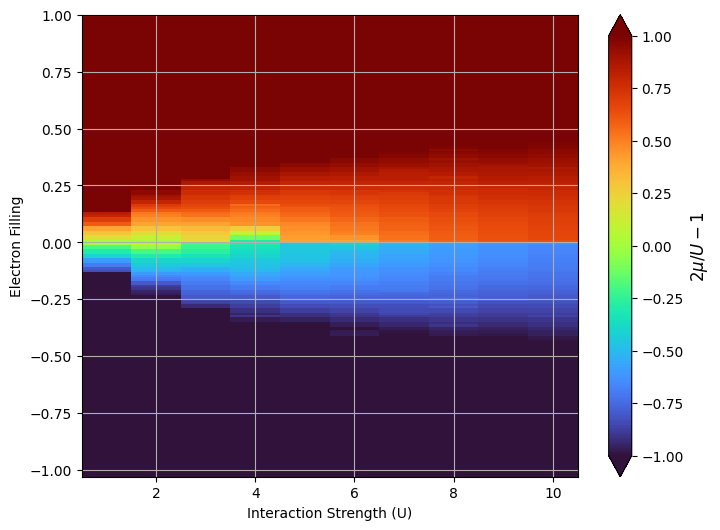

In [12]:
L = df["L"].values[0]
U = df['U'].values
filling_sum = np.array([np.sum(np.array(f)) for f in df['filling']])
chemical_potential = df['mu'].values
ground_state_energy = df["ground_state_energy"].values
double_occupancy = np.array([np.sum(np.array(f)) for f in df['double_occupancy']])
Neumann_entropy = np.array(df['Neumann_entropy'].to_list())

normalized_mu = 2 * chemical_potential / U - 1

vmin = -1
vmax = 1

x_label = 'Interaction Strength (U)'
y_label = 'Electron Filling'
cbar_label = r'$2\mu/U-1$'

plot_pcolormesh(
    L=L, U=U,
    filling_sum=filling_sum.real,
    vmin = vmin,
    vmax = vmax,
    data = normalized_mu,
    x_label = x_label,
    y_label = y_label,
    cbar_label = cbar_label,
)


data_grid min: nan max: nan
Any NaN in data_grid?: True


/tmp/ipykernel_2603/3611254759.py:11: RuntimeWarning: divide by zero encountered in log10
  data = np.log10(double_occupancy.real / L),


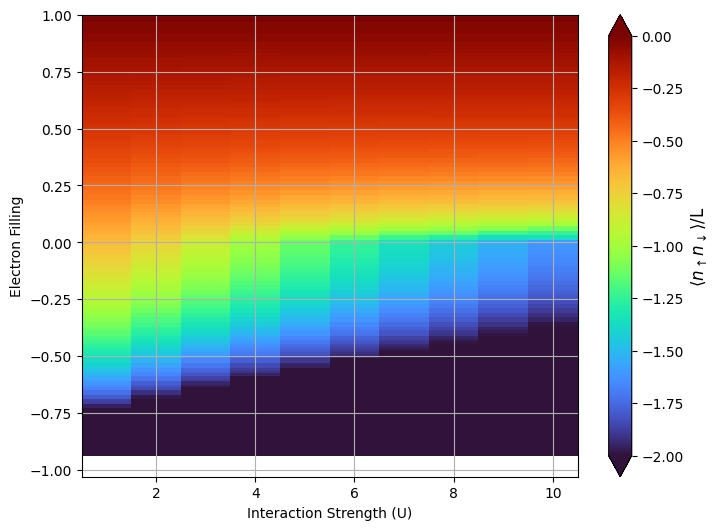

In [13]:
x_label = 'Interaction Strength (U)'
y_label = 'Electron Filling'
cbar_label = r'$\langle n_{\uparrow}n_{\downarrow}\rangle$/L'

vmin = -2
vmax = 0

plot_pcolormesh(
    L=L, U=U,
    filling_sum=filling_sum.real,
    data = np.log10(double_occupancy.real / L),
    vmin = vmin,
    vmax = vmax,
    x_label = x_label,
    y_label = y_label,
    cbar_label = cbar_label,
)


data_grid min: nan max: nan
Any NaN in data_grid?: True


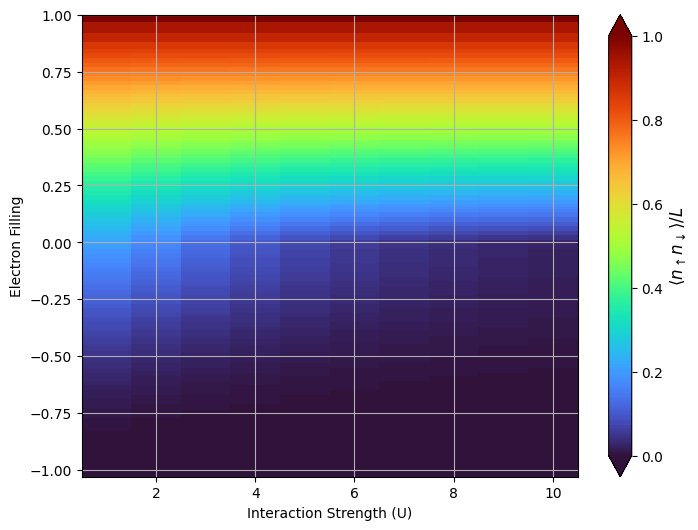

In [14]:
x_label = 'Interaction Strength (U)'
y_label = 'Electron Filling'
cbar_label = r'$\langle n_{\uparrow}n_{\downarrow}\rangle/L$'

vmin = 0
vmax = 1

plot_pcolormesh(
    L=L, U=U,
    filling_sum=filling_sum.real,
    data = (double_occupancy.real / L),
    vmin = vmin,
    vmax = vmax,
    x_label = x_label,
    y_label = y_label,
    cbar_label = cbar_label,
)


data_grid min: nan max: nan
Any NaN in data_grid?: True


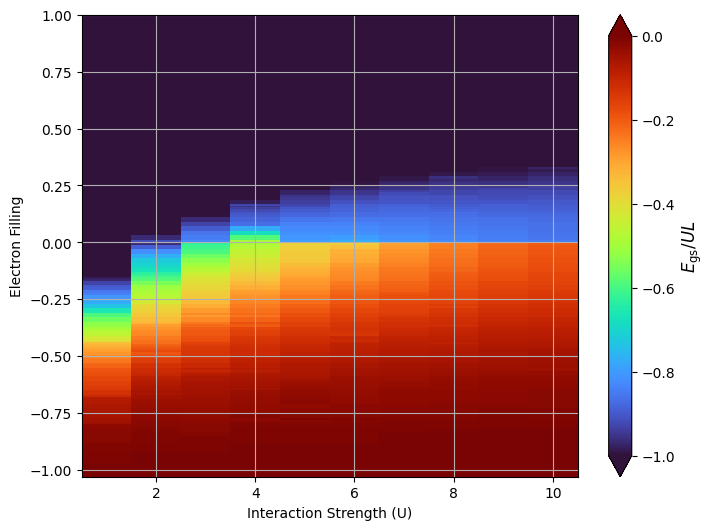

In [15]:
x_label = 'Interaction Strength (U)'
y_label = 'Electron Filling'
cbar_label = r'$E_\text{gs}/UL$'

vmin = -1
vmax = 0

plot_pcolormesh(
    L=L, U=U,
    filling_sum=filling_sum.real,
    data = (ground_state_energy.real / U / L),
    vmin = vmin,
    vmax = vmax,
    x_label = x_label,
    y_label = y_label,
    cbar_label = cbar_label,
)


In [16]:
# x_label = 'Interaction Strength (U)'
# y_label = 'Electron Filling'
# cbar_label = r'$E_\text{gs}/UL$'

# vmin = 0
# vmax = 2.5

# plot_pcolormesh(
#     L=L, U=U,
#     filling_sum=filling_sum.real,
#     data = Neumann_entropy[:,int((L-1)/2)].real,
#     vmin = vmin,
#     vmax = vmax,
#     x_label = x_label,
#     y_label = y_label,
#     cbar_label = cbar_label,
# )


data_grid min: nan max: nan
Any NaN in data_grid?: True


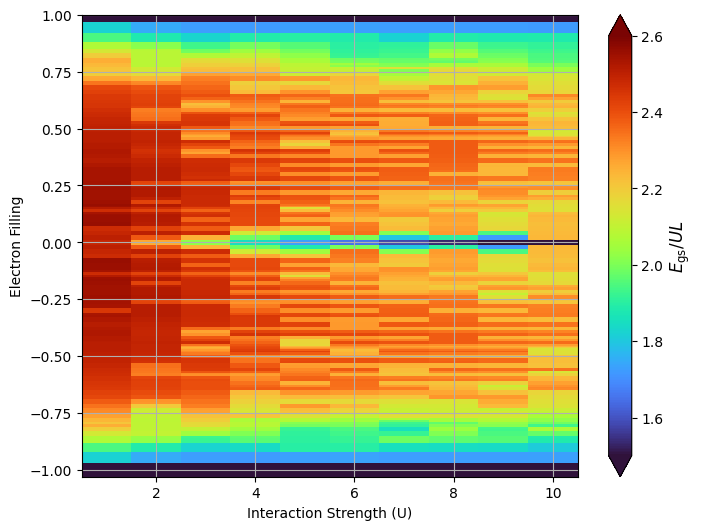

In [17]:
x_label = 'Interaction Strength (U)'
y_label = 'Electron Filling'
cbar_label = r'$E_\text{gs}/UL$'

vmin = 1.5
vmax = 2.6

plot_pcolormesh(
    L=L, U=U,
    filling_sum=filling_sum.real,
    data = Neumann_entropy.max(axis=1).real,
    vmin = vmin,
    vmax = vmax,
    x_label = x_label,
    y_label = y_label,
    cbar_label = cbar_label,
)


In [18]:
Neumann_entropy[75][24]

(2.3448636423058153+0j)

In [19]:
filling_sum[-1]

(100+0j)

/home/sungbinlee/miniconda3/envs/latest/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/sungbinlee/miniconda3/envs/latest/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


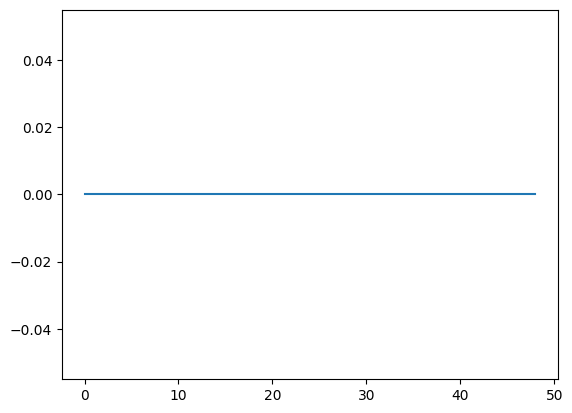

In [20]:
plt.plot(Neumann_entropy[-1])

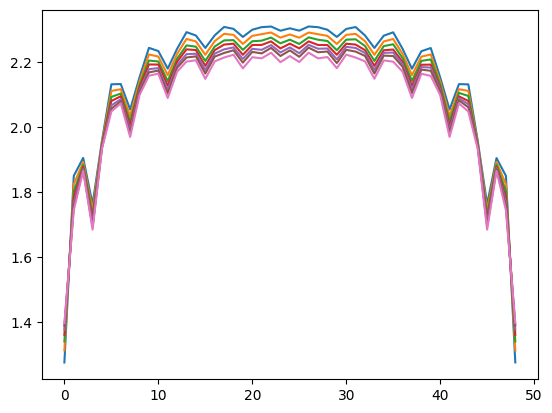

In [21]:
for filling, entropy in zip(filling_sum, Neumann_entropy):
    
    if np.abs(filling / L - 1.5) < 1e-2:
        plt.plot(entropy)